# Project 3

In [1]:
import pokebase as pb
pb.cache.API_CACHE

import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from scipy.stats import pearsonr

## Gathering all Generation 1 Pokemon from [PokeAPI](https://pokeapi.co/)

**Note: pinging PokeAPI for each pokemon object in generation 1 is a slow process. Expect this to take anywhere around 15-30 sec.*

In [2]:
gen1 = requests.get('https://pokeapi.co/api/v2/generation/1')
gen1 = json.loads(gen1.content)

gen1Moves = gen1['moves']   # a list of moves included in the gen 1 games
gen1Types = gen1['types']   # a list of valid pokemon types in the gen 1
gen1Species = gen1['pokemon_species']   # a list of pokemon species introduced in gen 1

# Get pokemon objects for each of the pokemon from gen 1
gen1Pokemon = []
for species in gen1Species:
    pokemon = requests.get(f"https://pokeapi.co/api/v2/pokemon/{species['name']}")
    pokemon = json.loads(pokemon.content)
    gen1Pokemon.append(pokemon)

In [3]:
# Optinally get the rest of the generations (takes about 8 minutes)
for i in range(2, 10): 
    gen = requests.get(f'https://pokeapi.co/api/v2/generation/{i}')
    if gen.status_code == 200:
        try:
            gen = json.loads(gen.content)
            genSpecies = gen['pokemon_species']
            genPokemon = []
            for species in genSpecies:
                pokemon = requests.get(f"https://pokeapi.co/api/v2/pokemon/{species['name']}")
                # Some Pokemon throw errors, probably because they have unique naming in the API
                if pokemon.status_code == 200:
                    try:
                        pokemon = json.loads(pokemon.content)
                        genPokemon.append(pokemon)
                    except json.JSONDecodeError:
                        print(f"Error decoding JSON for pokemon: {species['name']}")
                else:
                    print(f"Error retrieving pokemon: {species['name']}")
            # add to gen1Pokemon list
            gen1Pokemon += genPokemon
        except json.JSONDecodeError:
            print(f"Error decoding JSON for generation {i}")
    else:
        print(f"Error retrieving generation {i}")


Error retrieving pokemon: deoxys
Error retrieving pokemon: wormadam
Error retrieving pokemon: giratina
Error retrieving pokemon: shaymin
Error retrieving pokemon: basculin
Error retrieving pokemon: darmanitan
Error retrieving pokemon: tornadus
Error retrieving pokemon: thundurus
Error retrieving pokemon: landorus
Error retrieving pokemon: keldeo
Error retrieving pokemon: meloetta
Error retrieving pokemon: meowstic
Error retrieving pokemon: aegislash
Error retrieving pokemon: pumpkaboo
Error retrieving pokemon: zygarde
Error retrieving pokemon: gourgeist
Error retrieving pokemon: oricorio
Error retrieving pokemon: wishiwashi
Error retrieving pokemon: lycanroc
Error retrieving pokemon: minior
Error retrieving pokemon: mimikyu
Error retrieving pokemon: eiscue
Error retrieving pokemon: indeedee
Error retrieving pokemon: morpeko
Error retrieving pokemon: enamorus
Error retrieving pokemon: toxtricity
Error retrieving pokemon: urshifu
Error retrieving pokemon: basculegion


## Converting Pokemon JSON data into usable dataframes

In [4]:
# Create a dataframe for moves included in the gen 1 games
# (to be used in validating moves listed for each pokemon)
movesDF = pd.DataFrame(gen1Moves)
movesDF = movesDF[['name']]
movesDF.columns = ['move']
movesDF

,move
0,pound
1,karate-chop
2,double-slap
3,comet-punch
4,mega-punch
...,...
160,tri-attack
161,super-fang
162,slash
163,substitute


**Note: pinging PokeAPI for each move object is a slow process. Expect this to take anywhere around 15-30 sec.*

In [5]:
# Add more info about each move
for index, row in movesDF.iterrows():
    moveDetails = requests.get(f'https://pokeapi.co/api/v2/move/{row["move"]}')
    moveDetails = json.loads(moveDetails.content)
    movesDF.at[index, 'power'] = moveDetails['power']
    movesDF.at[index, 'damage_class'] = moveDetails['damage_class']['name']
    movesDF.at[index, 'type'] = moveDetails['type']['name']

movesDF

,move,power,damage_class,type
0,pound,40.0,physical,normal
1,karate-chop,50.0,physical,fighting
2,double-slap,15.0,physical,normal
3,comet-punch,18.0,physical,normal
4,mega-punch,80.0,physical,normal
...,...,...,...,...
160,tri-attack,80.0,special,normal
161,super-fang,NaN,physical,normal
162,slash,70.0,physical,normal
163,substitute,NaN,status,normal


In [38]:
# Create a dataframe of each pokemon and its various stats
pokemonDF = {
    'name': [],
    'generation': [],   # the generation the pokemon was introduced in
    'base_experience': [],  # experience gained from defeating this pokemon
    'height': [],   # in decimetres
    'weight': [],   # in hectograms
    'abilities': [],    # total number of abilities
    # 'moves': [],    # total number of moves learnable by this pokemon
    'type': [],
    'type-slot': [],    # denotes whether the recorded type is the pokemon's primary or secondary type
    # All stat values represent base stats
    'hp': [],
    'attack': [],
    'defense': [],
    'special-attack': [],
    'special-defense': [],
    'speed': [],
}

pokemonMovesDF = {  # all gen 1 moves learnable by pokemon in gen 1
    'name': [],
    'move': [],
    'level_learned_at': [],
}

for pokemon in gen1Pokemon:
    # Typings for some pokemon have changed since gen 1
    if len(pokemon['past_types']) > 0:
        typeList = pokemon['past_types'][0]['types']
    else:
        typeList = pokemon['types']

    for type in typeList:
        pokemonDF['type-slot'].append(type['slot'])
        pokemonDF['type'].append(type['type']['name'])

        pokemonDF['name'].append(pokemon['name'])
        thresholds = [152, 252, 387, 494, 650, 722, 810, 906]
        for i, threshold in enumerate(thresholds, 1):
            if pokemon['id'] < threshold:
                pokemonDF['generation'].append(i)
                break
        else:
            pokemonDF['generation'].append(len(thresholds) + 1)
        pokemonDF['base_experience'].append(pokemon['base_experience'])
        pokemonDF['height'].append(pokemon['height'])
        pokemonDF['weight'].append(pokemon['weight'])
        pokemonDF['abilities'].append(len(pokemon['abilities']))


        for stat in pokemon['stats']:
            pokemonDF[stat['stat']['name']].append(stat['base_stat'])

    # Add moves to a dictionary for now. 
    # Validity of these moves and a move count for each pokemon will be checked later
    for move in pokemon['moves']:
        pokemonMovesDF['name'].append(pokemon['name'])
        pokemonMovesDF['move'].append(move['move']['name'])
        pokemonMovesDF['level_learned_at'].append(move['version_group_details'][0]['level_learned_at'])
        
# Create a dataframe from the moves gathered from the pokemon
pokemonMovesDF = pd.DataFrame(pokemonMovesDF)
# Purge the overall moves list of non-gen-1 moves
pokemonMovesDF = pd.merge(pokemonMovesDF, movesDF, how='right')
# Interesting story: struggle is a move used by pokemon that have run out of all other moves,
# but is not itself a learnable move, thus the below is necessary
pokemonMovesDF = pokemonMovesDF.dropna(subset='name')
display(pokemonMovesDF)

# Count the number of valid gen 1 moves learnable by each pokemon
pokemonMoveCountsDF = pokemonMovesDF.groupby('name')['move'].count().reset_index()
pokemonMoveCountsDF.columns = ['name', 'moves']

# Create a dataframe of the pokemon stats
pokemonDF = pd.DataFrame(pokemonDF)
# Utilize a gen 1 types dataframe to get rid of any invalid types
typesDF = pd.DataFrame(gen1Types)
typesDF = typesDF[['name']]
typesDF.columns = ['type']
pokemonDF = pd.merge(pokemonDF, typesDF, how='right')

# Finally, add the move counts of each pokemon
pokemonDF = pd.merge(pokemonDF, pokemonMoveCountsDF)
pokemonDF['stat-total'] = pokemonDF['hp'] + pokemonDF['attack'] + pokemonDF['defense'] + pokemonDF['special-attack'] + pokemonDF['special-defense'] + pokemonDF['speed'] 
pokemonDF

,name,move,level_learned_at,power,damage_class,type
0,poliwag,pound,4.0,40.0,physical,normal
1,clefairy,pound,1.0,40.0,physical,normal
2,clefable,pound,1.0,40.0,physical,normal
3,jigglypuff,pound,9.0,40.0,physical,normal
4,wigglytuff,pound,1.0,40.0,physical,normal
...,...,...,...,...,...,...
22487,espathra,substitute,0.0,NaN,status,normal
22488,dipplin,substitute,44.0,NaN,status,normal
22489,sinistcha,substitute,0.0,NaN,status,normal
22490,archaludon,substitute,0.0,NaN,status,normal


,name,generation,base_experience,height,weight,abilities,type,type-slot,hp,attack,defense,special-attack,special-defense,speed,moves,stat-total
0,pidgey,1,50.0,3,18,3,normal,1,40,45,40,35,35,56,23,251
1,rattata,1,51.0,3,35,3,normal,1,30,56,35,25,35,72,33,253
2,spearow,1,52.0,3,20,2,normal,1,40,60,30,31,31,70,26,262
3,meowth,1,58.0,4,42,3,normal,1,40,45,35,40,40,90,34,290
4,pidgeotto,1,122.0,11,300,3,normal,1,63,60,55,50,50,71,23,349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,gouging-fire,9,NaN,35,5900,1,dragon,2,105,115,121,65,93,91,15,590
1313,raging-bolt,9,NaN,52,4800,1,dragon,2,125,73,91,137,89,75,13,590
1314,dipplin,9,NaN,4,97,3,dragon,2,80,80,110,95,80,40,11,485
1315,archaludon,9,NaN,20,600,3,dragon,2,90,105,130,125,65,85,19,600


**Keep in mind that a pokemon with two types will appear twice in this dataset and duplicates may need to be dropped for analyses not involving different typings.*

In [7]:
typeAveragesDF = pokemonDF.groupby('type').agg({
    'base_experience': 'mean',
    'height': 'mean',
    'weight': 'mean',
    'abilities': 'mean',
    'hp': 'mean',
    'attack': 'mean',
    'defense': 'mean',
    'special-attack': 'mean',
    'special-defense': 'mean',
    'speed': 'mean',
    'moves': 'mean',
    'stat-total': 'mean',
    'base_experience': 'mean',
}).reset_index()

typeAveragesDF

,type,base_experience,height,weight,abilities,hp,attack,defense,special-attack,special-defense,speed,moves,stat-total
0,bug,124.855422,9.087912,331.186813,2.329670,56.538462,68.109890,69.000000,56.538462,63.725275,60.417582,17.021978,374.329670
1,dragon,199.500000,22.132353,1536.044118,2.132353,82.750000,93.823529,81.941176,87.102941,77.411765,77.750000,20.882353,500.779412
2,electric,161.129630,11.045455,625.772727,2.318182,68.590909,73.621212,64.833333,83.378788,67.606061,81.303030,21.863636,439.333333
3,fighting,167.016949,13.774648,797.943662,2.478873,77.253521,104.422535,75.845070,62.676056,69.549296,74.633803,23.929577,464.380282
4,fire,163.289855,11.974684,697.430380,2.202532,69.430380,79.974684,67.670886,86.873418,71.202532,73.632911,24.075949,448.784810
5,flying,151.969072,13.291262,494.766990,2.543689,70.029126,75.310680,64.805825,69.388350,67.776699,81.582524,22.495146,428.893204
6,ghost,156.608696,11.694915,445.576271,1.983051,63.932203,76.661017,75.254237,83.406780,77.474576,65.135593,18.677966,441.864407
7,grass,142.873786,9.642276,335.341463,2.292683,66.048780,74.634146,70.975610,71.699187,71.455285,59.422764,20.707317,414.235772
8,ground,142.769231,15.178082,1277.082192,2.506849,76.465753,87.780822,84.904110,56.397260,64.136986,57.383562,25.424658,427.068493
9,ice,157.650000,14.595745,1328.702128,2.531915,80.191489,82.319149,75.000000,75.148936,74.872340,65.765957,21.425532,453.297872


## Base experience of pokemon by type

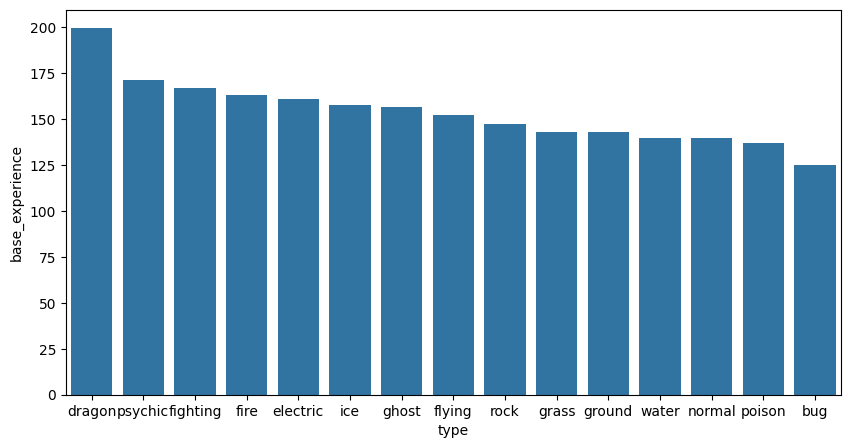

In [8]:
sns.barplot(x='type', y='base_experience', data=typeAveragesDF.sort_values(ascending=False, by='base_experience'))
fig = plt.gcf()
fig.set_size_inches(10, 5)

C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping 

TtestResult(statistic=nan, pvalue=nan, df=nan)

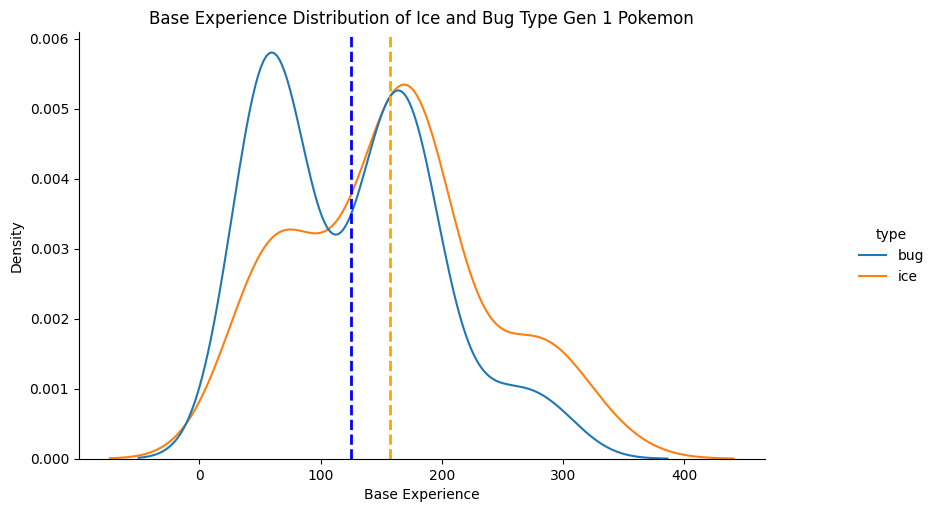

In [9]:
sns.displot(data=pokemonDF[pokemonDF['type'].isin(['ice','bug'])], x='base_experience',  hue='type', kind='kde', common_norm=False)

plt.title('Base Experience Distribution of Ice and Bug Type Gen 1 Pokemon')
plt.xlabel('Base Experience')

mean = typeAveragesDF[typeAveragesDF['type'] == 'bug']['base_experience'].astype(float).iloc[0]
# std = typeAveragesDF[typeAveragesDF['type'] == 'bug']['std'].astype(float).iloc[0]
plt.axvline(mean, color='blue', linestyle='dashed', linewidth=2, label='Mean')

mean = typeAveragesDF[typeAveragesDF['type'] == 'ice']['base_experience'].astype(float).iloc[0]
# std = typeAveragesDF[typeAveragesDF['type'] == 'ice']['std'].astype(float).iloc[0]
plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label='Mean')

fig = plt.gcf()
fig.set_size_inches(10, 5)

display(stats.ttest_ind(pokemonDF[pokemonDF['type'] == 'ice']['base_experience'], pokemonDF[pokemonDF['type'] == 'bug']['base_experience']))

In [10]:
lowestTypeStatsDF = pokemonDF.groupby('type').agg({
    'base_experience': 'min',
    'height': 'min',
    'weight': 'min',
    'abilities': 'min',
    'hp': 'min',
    'attack': 'min',
    'defense': 'min',
    'special-attack': 'min',
    'special-defense': 'min',
    'speed': 'min',
    'moves': 'min',
    'stat-total': 'min',
    'base_experience': 'min',
}).reset_index()

lowestTypeStatsDF.sort_values(by='base_experience')

,type,base_experience,height,weight,abilities,hp,attack,defense,special-attack,special-defense,speed,moves,stat-total
0,bug,36.0,1,2,1,1,10,20,10,20,5,1,180
7,grass,36.0,1,1,1,30,27,30,24,30,10,2,180
9,ice,37.0,3,38,1,30,25,15,30,30,20,2,185
10,normal,38.0,2,7,1,30,5,5,15,20,5,1,190
11,poison,39.0,2,1,1,30,25,30,20,20,15,2,195
12,psychic,40.0,1,1,1,20,20,15,23,30,15,1,198
14,water,40.0,3,10,1,10,10,20,10,20,5,3,200
2,electric,41.0,1,3,1,20,30,15,35,25,15,2,205
3,fighting,42.0,4,40,1,30,35,30,20,30,25,9,210
8,ground,42.0,2,8,1,10,40,25,20,25,10,11,210


In [11]:
highestTypeStatsDF = pokemonDF.groupby('type').agg({
    'base_experience': 'max',
    'height': 'max',
    'weight': 'max',
    'abilities': 'max',
    'hp': 'max',
    'attack': 'max',
    'defense': 'max',
    'special-attack': 'max',
    'special-defense': 'max',
    'speed': 'max',
    'moves': 'max',
    'stat-total': 'max',
    'base_experience': 'max',
}).reset_index()

highestTypeStatsDF.sort_values(by='base_experience', ascending=False)

,type,base_experience,height,weight,abilities,hp,attack,defense,special-attack,special-defense,speed,moves,stat-total
10,normal,635.0,37,4600,3,255,160,120,135,135,125,54,720
1,dragon,345.0,200,9500,3,223,150,135,150,150,142,53,690
11,poison,345.0,200,9500,3,140,130,160,145,142,130,53,690
2,electric,340.0,52,4800,3,154,150,120,173,115,200,38,680
4,fire,340.0,38,5900,3,115,130,140,151,154,126,46,680
5,flying,340.0,92,9999,3,150,150,140,150,154,160,53,680
6,ghost,340.0,40,3300,3,150,131,160,151,135,142,40,680
12,psychic,340.0,52,9999,3,190,137,131,154,154,130,85,680
14,water,340.0,145,3980,3,170,130,180,150,142,136,52,680
3,fighting,335.0,32,3807,3,154,140,139,137,129,151,45,670


## Stats of single-typed pokemon vs dual-typed pokemon

In [12]:
dualTypedDF = pokemonDF[pokemonDF['type-slot'] == 2]
display(dualTypedDF)
singleTypedDF = pokemonDF[~pokemonDF['name'].isin(dualTypedDF['name'])]
singleTypedDF

,name,base_experience,height,weight,abilities,type,type-slot,hp,attack,defense,special-attack,special-defense,speed,moves,stat-total
97,litleo,74.0,6,135,3,normal,2,62,50,58,73,54,72,19,369
100,pyroar,177.0,15,815,3,normal,2,86,68,72,109,66,106,20,507
101,helioptile,58.0,5,60,3,normal,2,44,38,33,61,43,70,21,289
102,heliolisk,168.0,10,210,3,normal,2,62,55,52,109,94,109,27,481
119,obstagoon,260.0,16,460,3,normal,2,93,90,101,60,81,95,31,520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,gouging-fire,NaN,35,5900,1,dragon,2,105,115,121,65,93,91,15,590
1313,raging-bolt,NaN,52,4800,1,dragon,2,125,73,91,137,89,75,13,590
1314,dipplin,NaN,4,97,3,dragon,2,80,80,110,95,80,40,11,485
1315,archaludon,NaN,20,600,3,dragon,2,90,105,130,125,65,85,19,600


,name,base_experience,height,weight,abilities,type,type-slot,hp,attack,defense,special-attack,special-defense,speed,moves,stat-total
1,rattata,51.0,3,35,3,normal,1,30,56,35,25,35,72,33,253
3,meowth,58.0,4,42,3,normal,1,40,45,35,40,40,90,34,290
6,raticate,145.0,7,185,3,normal,1,55,81,60,50,70,97,36,413
8,clefairy,113.0,6,75,3,normal,1,70,45,48,60,65,35,53,323
9,clefable,242.0,13,400,3,normal,1,95,70,73,95,90,60,54,483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,sliggoo,158.0,8,175,3,dragon,1,68,75,53,83,113,60,17,452
1282,goodra,300.0,20,1505,3,dragon,1,90,100,70,110,150,80,27,600
1287,jangmo-o,60.0,6,297,3,dragon,1,45,55,65,45,45,45,17,300
1299,regidrago,290.0,21,2000,1,dragon,1,200,100,50,100,50,80,15,580


,stat,average,typing
0,hp,72.952607,dual
1,attack,80.322275,dual
2,defense,76.225118,dual
3,special-attack,74.675355,dual
4,special-defense,72.758294,dual
5,speed,70.253555,dual


,stat,average,typing
0,hp,67.753346,single
1,attack,74.512428,single
2,defense,68.864245,single
3,special-attack,65.539197,single
4,special-defense,67.087954,single
5,speed,63.814532,single


C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


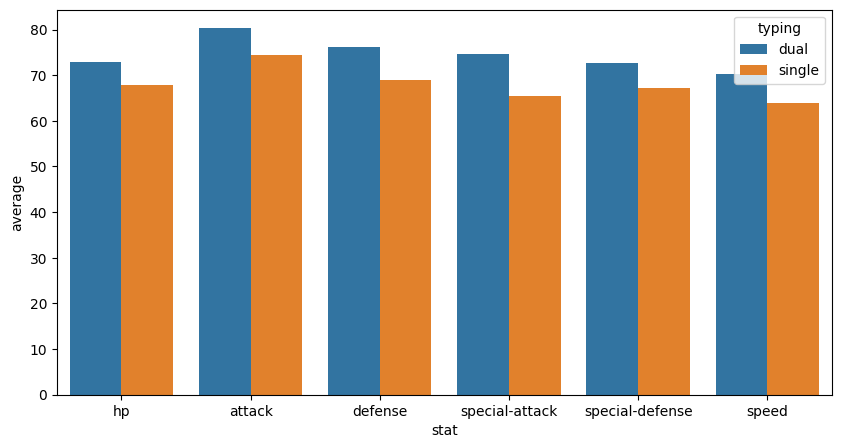

In [13]:
dualTypedAveragesDF = dualTypedDF[['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']].mean().reset_index()
dualTypedAveragesDF.columns = ['stat', 'average']
dualTypedAveragesDF['typing'] = 'dual'
display(dualTypedAveragesDF)

singleTypedAveragesDF = singleTypedDF[['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']].mean().reset_index()
singleTypedAveragesDF.columns = ['stat', 'average']
singleTypedAveragesDF['typing'] = 'single'
display(singleTypedAveragesDF)

typedAveragesDF = pd.concat([dualTypedAveragesDF, singleTypedAveragesDF]).reset_index()

sns.barplot(x='stat', y='average', hue='typing', data=typedAveragesDF)
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [14]:
statDifferentialsTotal = 0
for i in range(len(dualTypedAveragesDF['average'])):
    statDifferentialsTotal += abs(dualTypedAveragesDF['average'][i] - singleTypedAveragesDF['average'][i])
print(f'Total of individual stat average differentials: {statDifferentialsTotal}')

dualTypedStatTotalAverage = dualTypedDF[['stat-total']].mean().reset_index()
singleTypedStatTotalAverage = singleTypedDF[['stat-total']].mean().reset_index()
statTotalDifferential = dualTypedStatTotalAverage.iloc[0,1] - singleTypedStatTotalAverage.iloc[0,1]
print(f'Difference between average stat totals: {statTotalDifferential}')

Total of individual stat average differentials: 39.61550207062787
Difference between average stat totals: 39.61550207062788


In [15]:
display(stats.ttest_ind(dualTypedDF['hp'], singleTypedDF['hp']))
display(stats.ttest_ind(dualTypedDF['attack'], singleTypedDF['attack']))
display(stats.ttest_ind(dualTypedDF['defense'], singleTypedDF['defense']))
display(stats.ttest_ind(dualTypedDF['special-attack'], singleTypedDF['special-attack']))
display(stats.ttest_ind(dualTypedDF['special-defense'], singleTypedDF['special-defense']))
display(stats.ttest_ind(dualTypedDF['speed'], singleTypedDF['speed']))

display(stats.ttest_ind(dualTypedDF['stat-total'], singleTypedDF['stat-total']))

TtestResult(statistic=2.9694949684914955, pvalue=0.003058430582932051, df=943.0)

TtestResult(statistic=3.0019061840537407, pvalue=0.002753656216667125, df=943.0)

TtestResult(statistic=3.8682019136671393, pvalue=0.0001171724303831186, df=943.0)

TtestResult(statistic=4.772781925758381, pvalue=2.104986248085429e-06, df=943.0)

TtestResult(statistic=3.293539870445686, pvalue=0.001026149766527772, df=943.0)

TtestResult(statistic=3.4378294469305124, pvalue=0.0006120380598018254, df=943.0)

TtestResult(statistic=5.472294877681136, pvalue=5.6942332288635974e-08, df=943.0)

### Pokemon Speeds by Type
Let's look at the Speed stat on the pokemon and see if there are any significant differences between the types.

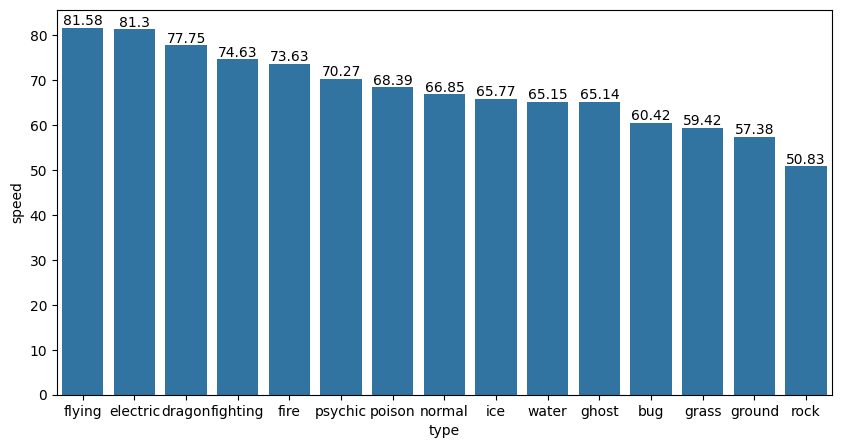

C:\Users\caden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


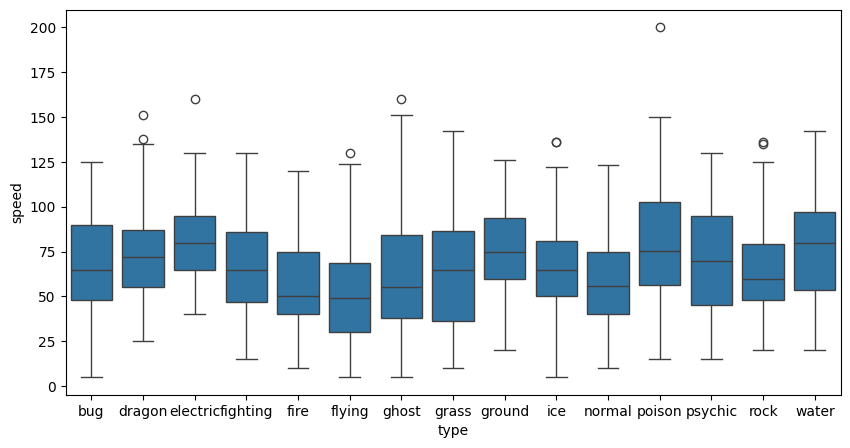

In [16]:
sns.barplot(x='type', y='speed', data=typeAveragesDF.sort_values(ascending=False, by='speed'))
for index, value in enumerate(typeAveragesDF.sort_values(ascending=False, by='speed')['speed']): # Speed values on the top
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

# box plot of speed
sns.boxplot(x='type', y='speed', data=pokemonDF)
# order from highest to lowest speed avg
order = typeAveragesDF.sort_values(ascending=False, by='speed')['type']
plt.xticks(order.index, order)

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()


Now let's look at the speed stat over generations to see if there is stat inflation. We can look at correlation between at stat and generation to see if there is a  relationship.

*(This requires pulling the full dataset of pokemon, not just generation 1)*

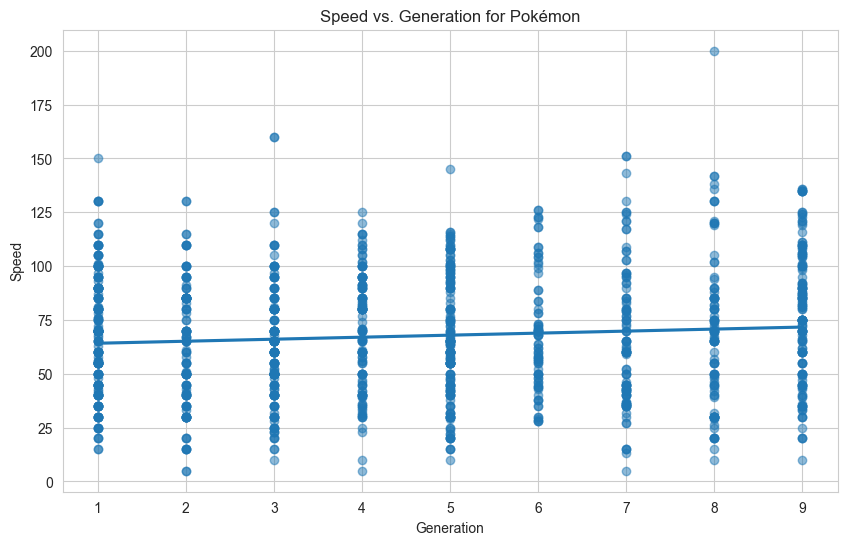

Pearson Correlation Coefficient: 0.08805344226682565
P-Value: 0.0013805670956755136


In [42]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(pokemonDF['generation'], pokemonDF['speed'])

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='generation', y='speed', data=pokemonDF, ci=None, scatter_kws={'alpha':0.5})
plt.title('Speed vs. Generation for Pokémon')
plt.xlabel('Generation')
plt.ylabel('Speed')
plt.show()

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-Value: {p_value}")
